## Imports and Helper Functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Loading and cleaning data

In [4]:
file = 'aarhus_parking.csv'
df_raw = pd.read_csv(file)

df_raw.head(10)

,vehiclecount,updatetime,_id,totalspaces,garagecode,streamtime
0,0,2014-05-22 09:09:04.145,1,65,NORREPORT,2014-11-03 16:18:44
1,0,2014-05-22 09:09:04.145,2,512,SKOLEBAKKEN,2014-11-03 16:18:44
2,869,2014-05-22 09:09:04.145,3,1240,SCANDCENTER,2014-11-03 16:18:44
3,22,2014-05-22 09:09:04.145,4,953,BRUUNS,2014-11-03 16:18:44
4,124,2014-05-22 09:09:04.145,5,130,BUSGADEHUSET,2014-11-03 16:18:44
5,106,2014-05-22 09:09:04.145,6,400,MAGASIN,2014-11-03 16:18:44
6,115,2014-05-22 09:09:04.145,7,210,KALKVAERKSVEJ,2014-11-03 16:18:44
7,233,2014-05-22 09:09:04.145,8,700,SALLING,2014-11-03 16:18:44
8,0,2014-05-22 09:39:01.803,9,65,NORREPORT,2014-11-03 16:18:44
9,0,2014-05-22 09:39:01.803,10,512,SKOLEBAKKEN,2014-11-03 16:18:44


In [5]:
df_raw.describe()

,vehiclecount,_id,totalspaces
count,55264.000000,55264.000000,55264.000000
mean,192.188387,27667.796468,526.250000
std,210.500021,15959.295617,388.536895
min,0.000000,1.000000,65.000000
25%,32.000000,13855.750000,190.000000
50%,96.000000,27671.500000,456.000000
75%,296.000000,41487.250000,763.250000
max,1464.000000,55303.000000,1240.000000


In [6]:
df_raw.dtypes

vehiclecount     int64
updatetime      object
_id              int64
totalspaces      int64
garagecode      object
streamtime      object
dtype: object

In [7]:
df = df_raw.copy()

In [12]:
# set time columns to datetimes
df['update_datetime'] = pd.to_datetime(df['updatetime'])
df['stream_datetime'] = pd.to_datetime(df['streamtime'])

In [14]:
# extract date and time
df['update_time'] = df['update_datetime'].dt.time
df['update_date'] = df['update_datetime'].dt.date

df['stream_time'] = df['stream_datetime'].dt.time
df['stream_date'] = df['stream_datetime'].dt.date

df = df.drop(columns=['updatetime', 'streamtime'])

<AxesSubplot: >

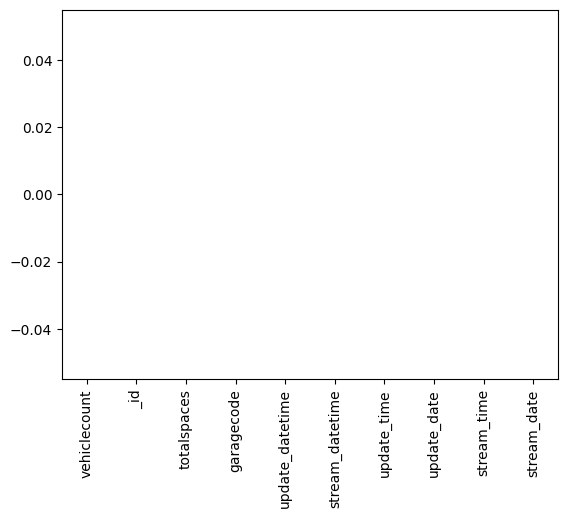

In [18]:
df.isna().sum().plot.bar()

In [23]:
df.update_datetime

0       2014-05-22 09:09:04.145
1       2014-05-22 09:09:04.145
2       2014-05-22 09:09:04.145
3       2014-05-22 09:09:04.145
4       2014-05-22 09:09:04.145
                  ...          
55259   2014-11-04 14:13:47.581
55260   2014-11-04 14:13:47.581
55261   2014-11-04 14:13:47.581
55262   2014-11-04 14:13:47.581
55263   2014-11-04 14:13:47.581
Name: update_datetime, Length: 55264, dtype: datetime64[ns]

In [28]:
unique_garagecodes = df['garagecode'].unique().tolist()

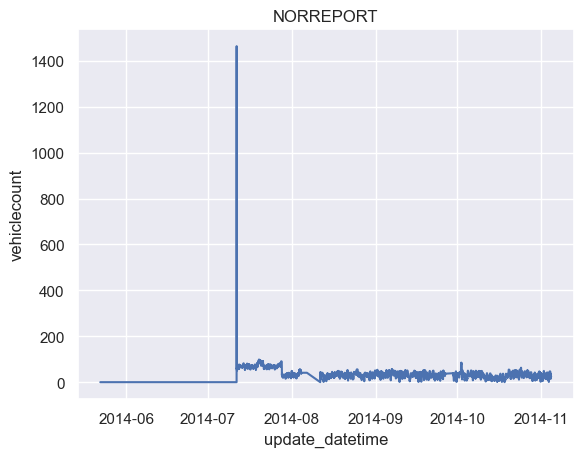

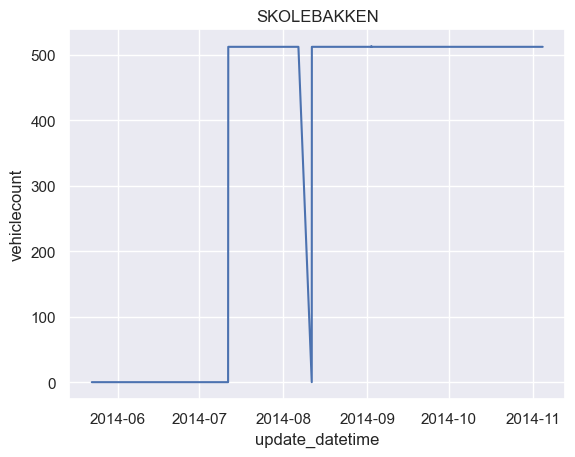

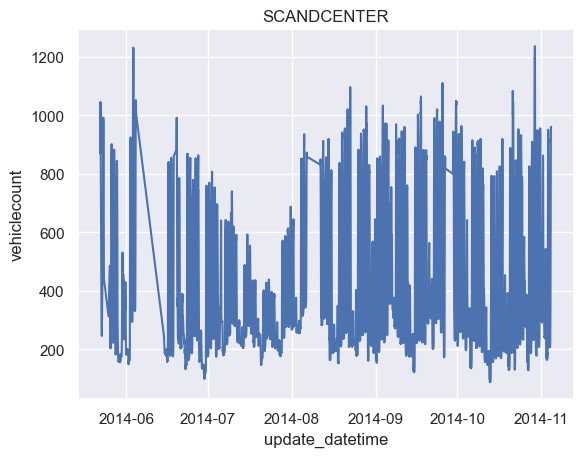

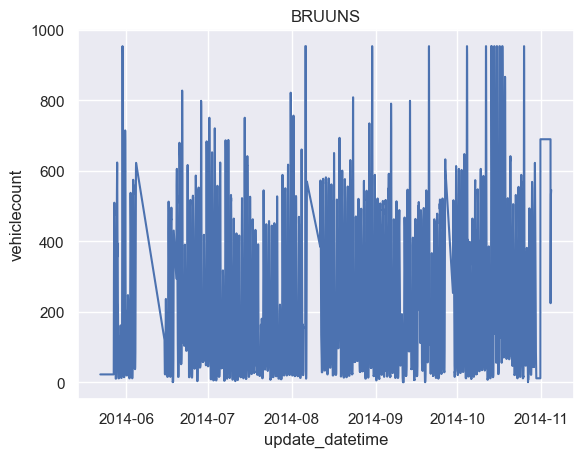

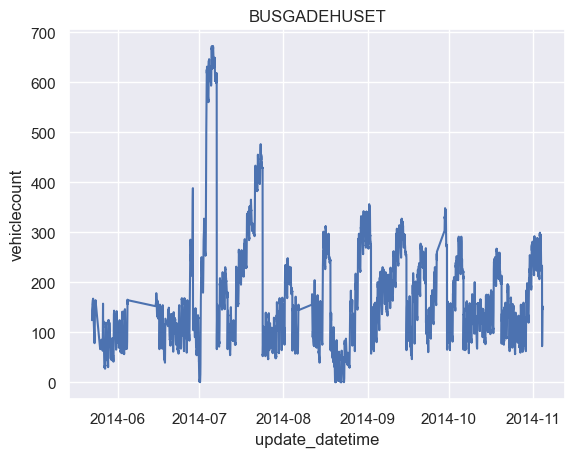

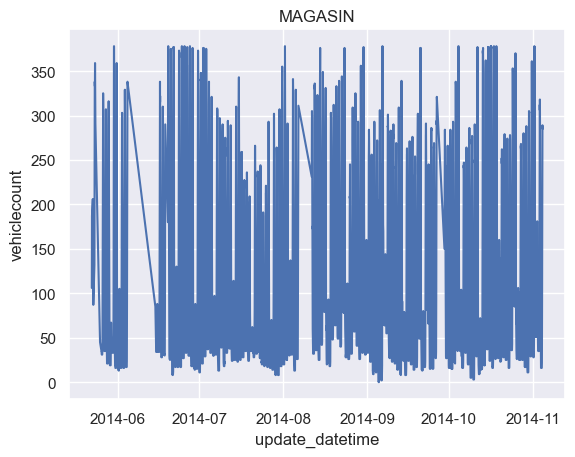

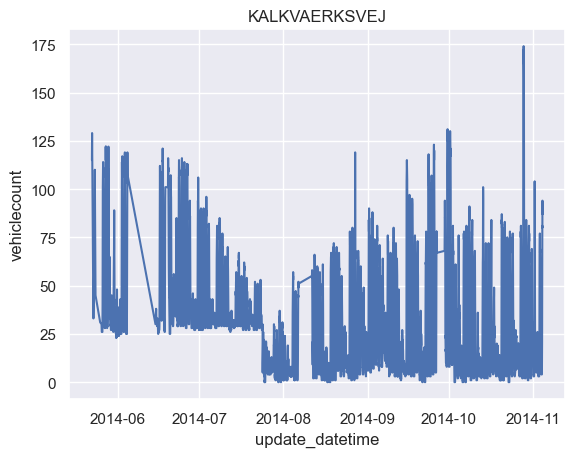

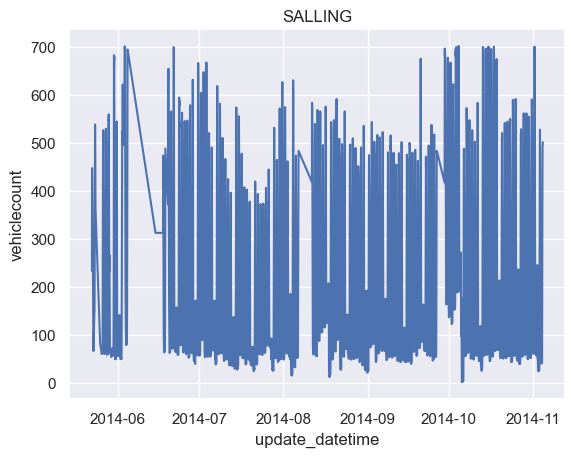

In [44]:
# 8 individual plots
for garage in unique_garagecodes:
    filtered_df = df[df['garagecode'] == garage]

    sns.lineplot(x='update_datetime', y='vehiclecount', data=filtered_df)
    plt.title(garage)
    plt.show()

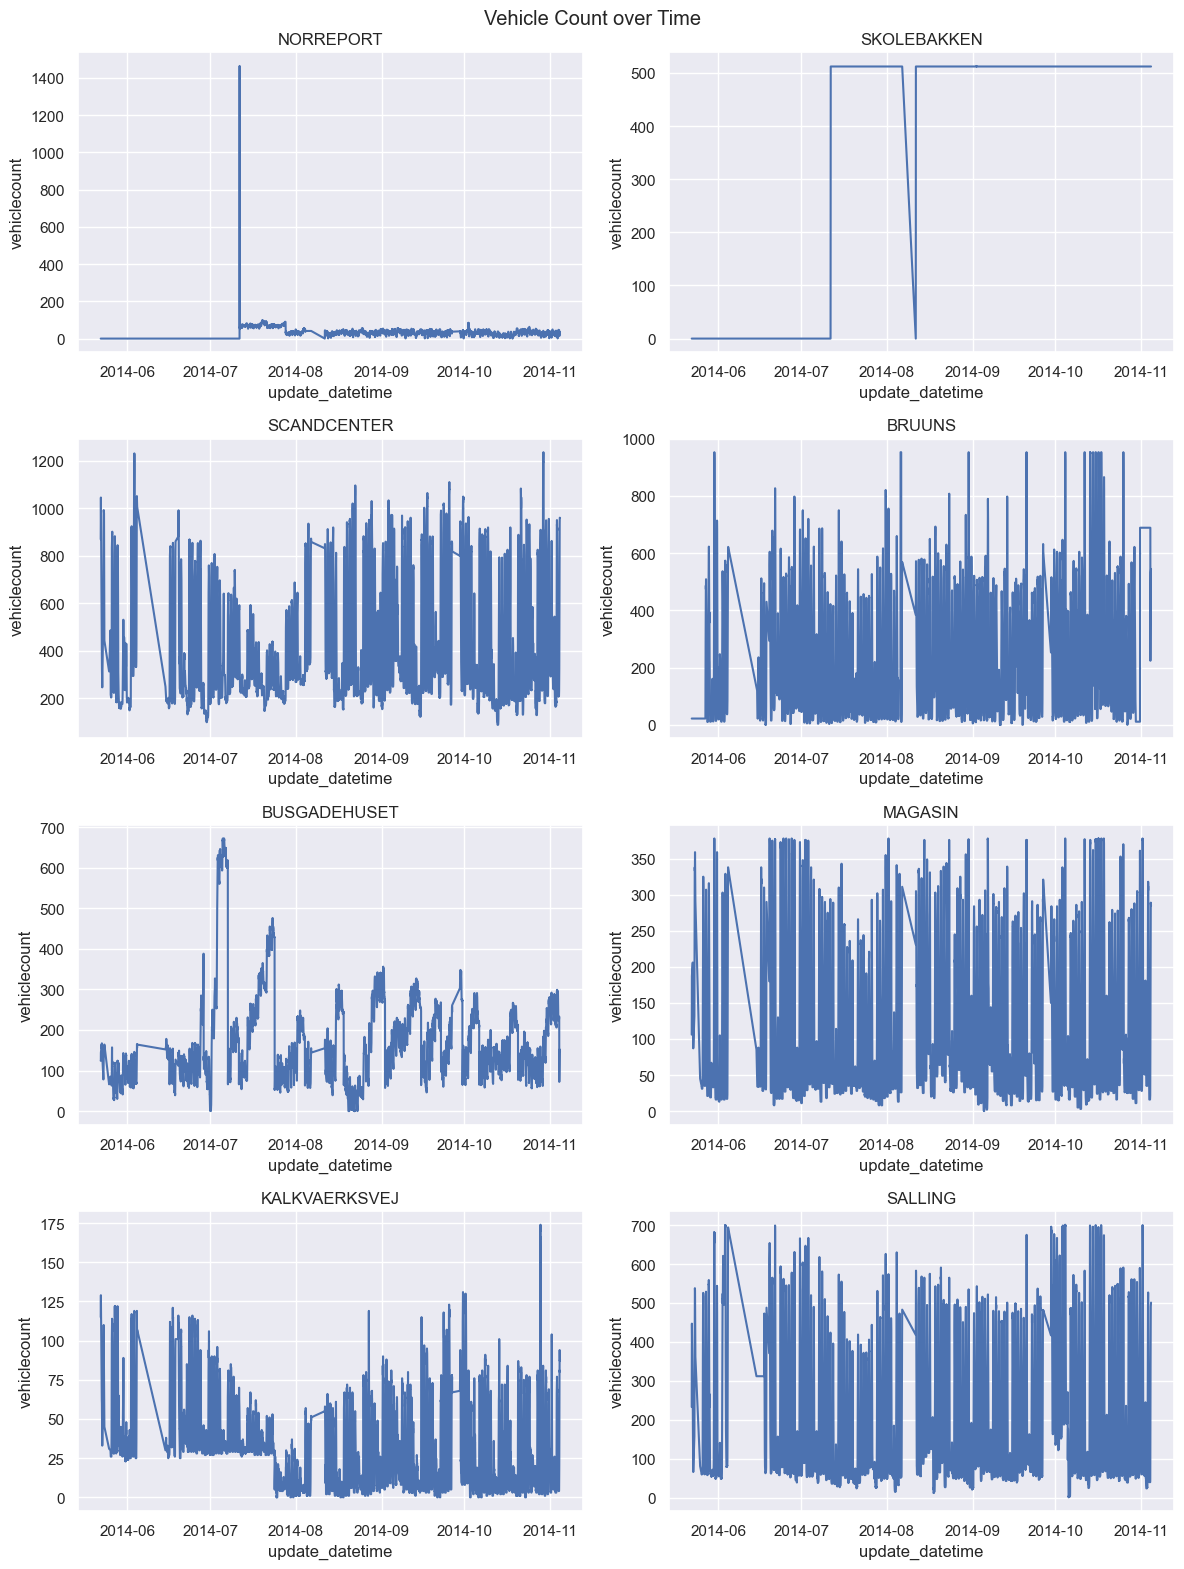

In [43]:
# 1 plot with 4x2 subplots

row_count = 4
col_count = 2

sns.set(style='darkgrid')
fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=(12,16))

for i, garage in enumerate(unique_garagecodes):
    row = i // col_count
    col = i % col_count
    filtered_df = df[df['garagecode'] == garage]

    sns.lineplot(x='update_datetime', y='vehiclecount', data=filtered_df, ax=axes[row, col])
    axes[row, col].set_title(garage)

plt.suptitle('Vehicle Count over Time')
plt.tight_layout()
plt.show()